<a href="https://colab.research.google.com/github/Mastroiani/TCC/blob/Sandbox/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install plotly
!pip install unidecode
!pip install wordcloud
!pip install nltk
!pip install lxml
!pip install graphviz

<h1>
    Bibliotecas
</h1>
<hr>

In [3]:
import pandas as pd
import numpy as np
from unidecode import unidecode

import os
import re
import matplotlib.pyplot as plt
from tqdm import tqdm

import nltk
from nltk import FreqDist
from string import punctuation
from wordcloud import WordCloud

import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image  
import pydotplus

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.naive_bayes import CategoricalNB
from sklearn.svm import SVC
from sklearn.externals.six import StringIO  

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



True

<h1>
   Leitura da base de dados .csv e definição do dataframe 'df'
</h1>
<hr>

In [4]:
#definindo lista 'df_list' de arquivos para leitura

path = '/content/drive/MyDrive/DADOSTCC'
df_list = []
for file_name in os.listdir(path):
    df_list.append(pd.read_csv(
        f'{path}/{file_name}',
        sep='@',
        encoding='latin1' # Necessidade de uso desse enconder pela presenca de letras nao lidas pelo UTF-8
    ))


IsADirectoryError: ignored

<h3>
    Criando o dataframe 'df', concatenando 'df_list'
</h3>

In [ ]:
df = pd.concat(df_list)

if(df.shape[1] > 25):
    df = df.iloc[:,:-1]

print(df.shape)
df.head()

<h2>Normalizando as colunas de 'df'</h2>
<hr>

In [ ]:
#transpõe rótulos das colunas para letras minúsculas e acrescenta "_" entre palavras
df.columns = ["_".join(re.findall(r'\w+',col)).lower() for col in df.columns]

#função 'norm_num': altera caracter "," para "." e "." para ""
def norm_num(num):
    return float(str(num).replace(".","").replace(",","."))

#função 'norm': usa biblioteca de expressões regulares para transpor palavras maiúsculas em minúsculas
def norm(text):
    return " ".join(re.findall(r'\w+',text)).lower()


In [ ]:
for column in [
    'qtde_estatistica',
    'peso_liquido',
    'vmle_dolar',
    'vl_frete_dolar',
    'vl_seguro_dolar',
    'valor_un_prod_dolar',
    'qtd_comercial',
    'tot_un_prod_dolar',
    'und_estat'
    ]:
    df[column] = df[column].apply(lambda x: norm_num(x))
    
df['unidade_desembaraco'] = df['unidade_desembaraco'].apply(lambda x: norm(x))
df['pais_de_origem'] = df['pais_de_origem'].apply(lambda x: norm(x))
df['pais_de_aquisicao'] = df['pais_de_aquisicao'].apply(lambda x: norm(x))

df.head()

<h1>Separando colunas</h1>
<ul>
    <li>Número de ordem -> ordem, adição e produto</li>
    <li>Ano e mês -> Ano e mês</li>
</ul>
<hr>

In [ ]:
numero_de_ordem = df['numero_de_ordem'].copy().astype(str).to_list()
ano_mes = df['anomes'].copy().astype(str).to_list()

In [ ]:
adicao = []
produto = []
ordem = []
ano = []
mes = []

for num_ordem, ano_me in zip(numero_de_ordem,ano_mes):
    ordem.append(num_ordem[:-10])
    adicao.append(num_ordem[-10:-5])
    produto.append(num_ordem[-5:])
    ano.append(ano_me[:4])
    mes.append(ano_me[-2:])

In [ ]:
df['numero_de_ordem'] = ordem
i = 1
for col in [['adicao',adicao],['produto',produto]]:
    try:
        df.insert(i,col[0],col[1]) # adicionando a coluna adicao
    except:
        print('Coluna ja existente')
    finally:
        i += 1
        
df.insert(3,'ano',ano)
df.insert(4,'mes',mes)

df.drop(['anomes'],axis=1,inplace=True)
df.sort_values(by=['ano'],inplace=True)

In [ ]:
df.head(2)

<h1>Verificando dados incompletos (nulos) e redundantes (duplicados)</h1>
<hr>

In [ ]:
print(df.isna().sum())
df.dropna(inplace=True)

In [ ]:
df.isnull().sum()

In [ ]:
df.duplicated(['numero_de_ordem','adicao','produto','ano','mes']).sum()

<h1>Criando dataframe 'df_filtrado', filtrando atributos de interesse de 'df'</h1>
<hr>
<ul>
    <li>NCM: <strong>72172090</strong></li>
    <li>Natureza Informação: <strong>efetiva</strong></li>
    <li>Situação do Despacho: <strong>di desembaraçada</strong></li>
</ul>

In [ ]:
df_filtrado = df[df['cod_ncm'] == 72172090].copy()
df_filtrado['nat_informacao'] = df_filtrado['nat_informacao'].apply(lambda x: norm(x))
df_filtrado['situacao_do_despacho'] = df_filtrado['situacao_do_despacho'].apply(lambda x: norm(x))

df_filtrado = df_filtrado[df_filtrado['nat_informacao'] == 'efetiva']
df_filtrado = df_filtrado[df_filtrado['situacao_do_despacho'] == 'di desembaraçada']

df_filtrado.shape

<h1>Agrupando e rateando valores de:</h1>
<ul>
    <li>Peso Liquido</li>
    <li>Valor Frete</li>
    <li>Valor Seguro</li>
    <li>Total Unitário</li>
</ul>
<hr>

In [ ]:
grupos_index = df_filtrado['numero_de_ordem'].value_counts().index
grupos_index

<h3>Peso Liquido Rataedo e Valor Frete Rateado</h3>

In [ ]:
list_aux = [] # objeto auxiliar de armazenamento das variáveis 'peso_liquido_rateado' e 'valor_frete_rateado' que serão criadas abaixo

for grupo in tqdm(grupos_index): #agrupando 'adicao' do mesmo 'numero_de_ordem' 
    aux = df_filtrado[df_filtrado['numero_de_ordem'] == grupo].copy() 
    
    sub_grupos_adicao = aux['adicao'].value_counts().index
    
    for sub_adicao in sub_grupos_adicao:  #agrupando produtos da mesmo 'adicao'
        aux_2 = aux[aux['adicao'] == sub_adicao].copy()
        
        qtd_comercial = aux_2['qtd_comercial'] #soma qtd comercial de produtos agrupados por 'numero_de_ordem' e 'adicao'
        soma_qtd_comercial = sum(qtd_comercial)

        
        peso_liquido = aux_2['peso_liquido']
        vl_frete_dolar = aux_2['vl_frete_dolar']
        

        aux_2['peso_liquido_rateado'] = (qtd_comercial/soma_qtd_comercial)*peso_liquido
        aux_2['valor_frete_rateado'] = (qtd_comercial/soma_qtd_comercial)*vl_frete_dolar

        list_aux.append(aux_2)
        
        
df_filtrado = pd.concat(list_aux)
df_filtrado.shape

<h3>Seguro Rateado</h3>

In [ ]:
list_aux = [] # objeto auxiliar de armazenamento da variáveis 'seguro_rateado'
for grupo in tqdm(grupos_index):
    aux = df_filtrado[df_filtrado['numero_de_ordem'] == grupo].copy()
    
    sub_grupos_adicao = aux['adicao'].value_counts().index
    
    for sub_adicao in sub_grupos_adicao:
        aux_2 = aux[aux['adicao'] == sub_adicao].copy()
        
        total_unitario = aux_2['tot_un_prod_dolar']
        soma_total_unitario = sum(total_unitario)
        

        vl_seguro_dolar = aux_2['vl_seguro_dolar']
        aux_2['seguro_rateado'] = (total_unitario/soma_total_unitario)*vl_seguro_dolar

        list_aux.append(aux_2)
        
        
df_filtrado = pd.concat(list_aux)

In [ ]:
df_filtrado.shape

<h3>Total Unitario Rateado</h3>
<p>Necessário subtrair 'valor_frete_rateado' e 'seguro_rateado' para INCOTERMS distintos de FOB/FCA/EXW</p>

In [ ]:
total_unitario_list = [] # objeto auxiliar de armazenamento da variáveis 'total_unitario_rateado'
for row_ in tqdm(df_filtrado.iloc,total=df_filtrado.shape[0]):
    total_unitario = row_['tot_un_prod_dolar']
    
    if(row_['incoterm'][0] == 'F' or row_['incoterm'][0] == 'E'):
        total_unitario_list.append(total_unitario)
    else:
        total_unitario_list.append(total_unitario - row_['valor_frete_rateado'] - row_['seguro_rateado'])

df_filtrado['total_unitario_rateado'] = total_unitario_list

In [ ]:
df_filtrado.shape

<h3>Criando Coluna FOB/KG</h3>
<p>Dividindo a coluna calculada <em><strong>total_unitario_rateado</strong></em> pela coluna calculada <em><strong>peso_liquido_rateado</strong></em></p>
<hr>

In [ ]:
df_filtrado['fob_kg'] = df_filtrado['total_unitario_rateado']/df_filtrado['peso_liquido_rateado']

<h3>Remoção de unidades comerciais (atributos) não relevantes</h3>
<hr>

<p>Obs.: esse ajuste visa considerar apenas os registros de produtos com unidade comercial relacionada a unidade estatística (Kg)</p> 

In [ ]:
df_filtrado['unidade_comerc'] = df_filtrado['unidade_comerc'].apply(lambda x: x.lower())

<p>Verificando as unidades comerciais presentes</p>

In [ ]:
freq_unid_com = FreqDist(df_filtrado['unidade_comerc'].values)
freq_unid_com

<p>Removendo:</p>
        <ul>
            <li><strong>caixa</strong></li>
            <li><strong>caixas</strong></li>
            <li><strong>carretel</strong></li>
            <li><strong>pacote</strong></li>
            <li><strong>pacotes</strong></li>
            <li><strong>peca</strong></li>
            <li><strong>pecas</strong></li>
            <li><strong>peças</strong></li>
            <li><strong>pé</strong></li>
            <li><strong>rolo</strong></li>
            <li><strong>rolos</strong></li>
            <li><strong>sachet</strong></li>
            <li><strong>sacos</strong></li>
            <li><strong>unidade</strong></li>
            <li><strong>metro</strong></li>
            <li><strong>metros</strong></li>
        </ul>

In [ ]:
def search_unid_comer(text):
    
    text = norm(text)
    achou = False
    for comparador in [
        'caixa',
        'caixas',
        'carretel',
        'pacote',
        'pacotes',
        'peca',
        'pecas',
        'peças',
        'pé',
        'rolo',
        'rolos',
        'sachet',
        'sacos',
        'unidade',
        'metro', # arrumar para tirar somente que for exatamente igual
        'metros' # arrumar para tirar somente que for exatamente igual
        ]:
        if(comparador in ['metro','metros']):
            if(text == comparador):
                achou = True
                return False
        elif(re.search(unidecode(comparador),unidecode(text))):
            achou = True
            return False
    if(not achou):
        return text

df_filtrado['unidade_comerc'] = df_filtrado['unidade_comerc'].apply(lambda x: search_unid_comer(x))
df_filtrado = df_filtrado[df_filtrado['unidade_comerc'] != False]

print(df_filtrado.shape)

<h3>Descrição do Produto</h3>
<hr>

<p>Obs.: esse ajuste visa considerar apenas os registros de produtos com descrição de produto sem menção de cobertura, pintura e/ou com aplicação especial (óptica)</p>

In [ ]:
df_filtrado['descricao_do_produto'] = df_filtrado['descricao_do_produto'].apply(lambda x: x.lower())

# função para remover stopwords e tokenizar
def norm_nltk(text):
    stop_word = nltk.corpus.stopwords.words('portuguese')

    tokens = nltk.word_tokenize(text.lower(),language='portuguese')
    tokens = [token for token in tokens if token not in stop_word]
    tokens = [token for token in tokens if token not in punctuation]

    aux = []
    for token in tokens:
        if(not re.findall(r'[0-9]+',token)):
            aux.append(unidecode(token))
    tokens = aux
    return " ".join(tokens)

df_filtrado['descricao_do_produto'] = df_filtrado['descricao_do_produto'].apply(lambda x: norm_nltk(x))

In [ ]:
df_filtrado['descricao_do_produto'].head()

In [ ]:
plt.subplots(figsize = (15,10))

wordcloud = WordCloud (
                    background_color = 'white',
                    width = 512,
                    height = 384
                        ).generate(' '.join(df_filtrado['descricao_do_produto']))
plt.imshow(wordcloud) 
plt.axis('off')
plt.show()

In [ ]:
ls_df_filtrado = list(df_filtrado['descricao_do_produto'].values)
str_ls = " ".join(ls_df_filtrado)
#print(str_ls)
palavras=nltk.word_tokenize(str_ls)
freq_desc_prod = FreqDist(palavras)
freq_desc_prod 

<p>Removendo produtos de descrição com palavras verificadas como não relevantes:</p>
        



In [ ]:
def search_desc_prod(text):
    text = text.lower()
    achou = False
    for comparador in [
            'aluminio',
            'aluminio-liga',
            'plastico',
            'plasticos',
            'plasticos.utilizacao',
            'pvc',
            'policloreto',
            'polietileno',
            'polimericos',
            'polimeros',
            'polipropileno',
            'vinila',
            'preto',
            'prata',
            'branca',
            'branco',
            'verde',
            'azul',
            'brilho',                     
            'otica',
            'optico',
            'optica',
            'mascara',
            'mascaras',
            'mask',
            'laca'            
        ]:
        
        if(re.search(unidecode(comparador),unidecode(text))):
            achou = True
            return False
    if(not achou):
        return text

df_filtrado['descricao_do_produto'] = df_filtrado['descricao_do_produto'].apply(lambda x: search_desc_prod(x))
df_filtrado = df_filtrado[df_filtrado['descricao_do_produto'] != False]

<h3>Tamanho do DataFrame final</h3>
<hr>

In [ ]:
df_filtrado.shape

<h1>Comparando valor FOB/KG com valor de cotação mensal internacional da matéria-prima (Wire Rod - Fio Máquina)</h1>
<hr>

<h3>Leitura dos dados de cotação da página web de referência</h3>

In [ ]:
URL = 'https://mepsinternational.com/gb/en/products/world-steel-prices'

df_wire_rod = pd.read_html(URL,match='Wire Rod')[0]
df_wire_rod

<h3>Definindo dataframe 'df_wire_rod'</h3>

In [ ]:
df_wire_rod = df_wire_rod[['Month','Wire Rod']].copy().dropna()
df_wire_rod['Wire Rod'] = df_wire_rod['Wire Rod'].apply(lambda x: x/1000)
df_wire_rod

In [ ]:
#exportando 'df_wire_rod' em formato csv
df_wire_rod.to_csv('/content/drive/MyDrive/wire_rod.csv',index=False)

<h3>Visualização gráfica da evolução da cotação do Wire Rod</h3>

In [ ]:
fig = px.line(
    df_wire_rod,
    x="Month", 
    y="Wire Rod", 
    title="Variação do Wire Rod",
    text='Wire Rod'
)
fig.update_traces(textposition="bottom right")
fig.show()

<h3>Comparação</h3>
<p>Comparação do <strong>valor FOB/KG do produto manufaturado</strong> com o valor de <strong> cotação mensal internacional da matéria-prima (Wire Rod)</strong>; visa identificar se existe incompatibilidade de valor declarado (1 - True) ou não (0 - False)</p>

In [ ]:
map_mes = {
    '01': 'Jan',
    '02': 'Feb',
    '03': 'Mar',
    '04': 'Apr',
    '05': 'May',
    '06': 'Jun',
    '07': 'Jul',
    '08': 'Aug',
    '09': 'Sep',
    '10': 'Oct',
    '11': 'Nov',
    '12': 'Dec'
    }

In [ ]:
aux = []
wire_rod_list = []
for row_ in df_filtrado.iloc:
    
    try:
        wire_rod = df_wire_rod[df_wire_rod['Month'] == f"{map_mes[row_['mes']]}-{row_['ano']}"]['Wire Rod'].values[0]
        wire_rod_list.append(wire_rod)
        if(row_['fob_kg'] < wire_rod):
            aux.append(1)
        else:
            aux.append(0)
    except:
        aux.append(None)
        wire_rod_list.append(None)
        
df_filtrado['cotacao'] = wire_rod_list
df_filtrado['incompatibil'] = aux

In [ ]:
df_filtrado.shape

<h1>Visualização dos dados</h1>
<hr>

In [ ]:
df_filtrado.reset_index(inplace=True,drop=True)

expo_df = df_filtrado[[
    'numero_de_ordem',
    'adicao',
    'produto',
    'ano',
    'mes',
    'pais_de_origem',
    'unidade_desembaraco',
    'pais_de_aquisicao',
    'peso_liquido',
    'qtd_comercial',
    'vl_frete_dolar',
    'vl_seguro_dolar',
    'tot_un_prod_dolar',
    'peso_liquido_rateado',
    'valor_frete_rateado',
    'seguro_rateado',
    'total_unitario_rateado',
    'fob_kg',
    'cotacao',
    'incompatibil'
]]
expo_df['incompatibil'] = expo_df['incompatibil'].apply(lambda x: 'Sim' if x == 1 else 'Nao')
expo_df.head()

In [ ]:
print(expo_df.isna().sum())

In [ ]:
expo_df[expo_df['cotacao'].isna()]

In [ ]:
fig = px.scatter(expo_df,x='fob_kg', y='peso_liquido')#color='incompatibil')

fig.show()

In [ ]:
fig = px.scatter(expo_df,x='unidade_desembaraco', y='pais_de_origem',color='incompatibil')
fig.show()

<h1>Nota</h1>
<p>Reduzimos a proporção dos dados através do <strong>Logarítmico</strong>, uma técnica usada para melhor visualização dos dados</p>

In [ ]:
import plotly.graph_objects as go

for year in ['2020','2021']:
    medias = []


    df_2021 = df_filtrado[df_filtrado['ano'] == year]
    mes_grupos = df_2021['mes'].value_counts().index
    for mes_grup in mes_grupos:
        medias.append([mes_grup,df_2021[df_2021['mes'] == mes_grup]['fob_kg'].to_list()])

    medias = sorted(medias,key=lambda x: x[0])
    
    fig = go.Figure()
    for x in medias:
        fig.add_trace(go.Box(y=[np.log2(y) for y in x[1]],name=map_mes[x[0]]))

    fig.update_layout(
        title=go.layout.Title(
            text=f"Análise durante o ano de {year}",
            xref="paper",
            x=0
        )
        )

    fig.show()

In [ ]:
info_pais_origem = df_filtrado[df_filtrado['incompatibil'] == 1]['pais_de_origem'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


fig = go.Figure([go.Bar(x=values, y=labels, orientation='h')])
fig.update_layout(
    title=go.layout.Title(
        text="Países de origem <br><sup>Produtos com valor declarado incompatível",
        xref="paper",
        x=0
    )
    )
fig.show()

In [ ]:
info_pais_origem = df_filtrado[df_filtrado['incompatibil'] == 1]['pais_de_origem'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

In [ ]:
info_pais_origem = df_filtrado['pais_de_origem'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


fig = go.Figure([go.Bar(x=values, y=labels, orientation='h')])
fig.update_layout(
    title=go.layout.Title(
        text="Países de origem <br><sup>Todos Produtos",
        xref="paper",
        x=0
    )
    )
fig.show()

In [ ]:
info_pais_origem = df_filtrado['pais_de_origem'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

In [ ]:
info_pais_origem = df_filtrado[df_filtrado['incompatibil'] == 1]['pais_de_aquisicao'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


fig = go.Figure([go.Bar(x=values, y=labels, orientation='h')])
fig.update_layout(
    title=go.layout.Title(
        text="País de Aquisição<br><sup>Produtos com valor declarado incompatível</sup>",
        xref="paper",
        x=0
    )
    )
fig.show()

In [ ]:
info_pais_origem = df_filtrado[df_filtrado['incompatibil'] == 1]['pais_de_origem'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

In [ ]:
info_pais_origem = df_filtrado['pais_de_aquisicao'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


fig = go.Figure([go.Bar(x=values, y=labels, orientation='h')])
fig.update_layout(
    title=go.layout.Title(
        text="País de Aquisição<br><sup>Todos Produtos</sup>",
        xref="paper",
        x=0
    )
    )
fig.show()

In [ ]:
info_pais_origem = df_filtrado['pais_de_origem'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

In [ ]:
info_pais_origem = df_filtrado[df_filtrado['incompatibil'] == 1]['unidade_desembaraco'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


fig = go.Figure([go.Bar(x=values, y=labels, orientation='h')])
fig.update_layout(
    title=go.layout.Title(
        text="Unidade de desembaraço<br><sup>Produtos com valor declarado incompatível</sup>",
        xref="paper",
        x=0
    )
    )
fig.show()

In [ ]:
info_pais_origem = df_filtrado[df_filtrado['incompatibil'] == 1]['unidade_desembaraco'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

In [ ]:
info_pais_origem = df_filtrado['unidade_desembaraco'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


fig = go.Figure([go.Bar(x=values, y=labels, orientation='h')])
fig.update_layout(
    title=go.layout.Title(
        text="Unidade de desembaraço<br><sup>Todos Produtos</sup>",
        xref="paper",
        x=0
    )
    )
fig.show()

In [ ]:
info_pais_origem = df_filtrado['unidade_desembaraco'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

<h3>Exportando tabela em formato .csv</h3>

In [ ]:
path = '/content/drive/MyDrive'
name = 'dataset_preprocessado_TCC'

if(not os.path.exists(path)):
    os.mkdir(path)

df_filtrado.to_csv(f'{path}/{name}',index=False)

<h1>Importando tabela exportada</h1>
<hr>

In [ ]:
path = '/content/drive/MyDrive'
name = 'dataset_preprocessado_TCC'

df = pd.read_csv(f'{path}/{name}')

df.dropna(inplace=True)
df.reset_index(inplace=True,drop=True)
df.shape

<h3>Transformando atributo 'unidade_desembaraço' em variáveis numéricas</h3>

In [ ]:
#Transformando atributo 'unidade_desembaraço' em variáveis numéricas
map_portos = {porto:num for num,porto in enumerate(df['unidade_desembaraco'].value_counts().index)}

df['unidade_desembaraco'] = df['unidade_desembaraco'].apply(lambda x: map_portos[x])

<h1>Machine Learning - Desenvolvimento dos Modelos</h1>
<hr>
<h2>Treinamento</h2>
<h3>Colunas usadas para o treinamento</h3>
<ul>
    <li>País de Origem</li>
    <li>País de Aquisição</li>
    <li>Unidade Desembaraco</li>
    <li>Quantidade Estatística</li>
    <li>Peso líquido</li>
    <li>Vmle</li>
    <li>Frete</li>
    <li>Seguro</li>
    <li>Produção</li>
    <li>Quantidade comercial</li>
<ul>

In [ ]:
#definindo variáves usadas no treinamento (X) e variável target (y)

X = df[['pais','pais_1','unidade_desembaraco',
       'qtde_estatistica',
       'vmle_dolar',
       'vl_frete_dolar',
       'vl_seguro_dolar',
       'valor_un_prod_dolar',
       'qtd_comercial',
       'tot_un_prod_dolar',
       'peso_liquido_rateado',
       'valor_frete_rateado',
       'seguro_rateado',
       'total_unitario_rateado',
       'fob_kg'
       ]]

y = df[['incompatibil']]#['abaixo_fob_kg']

i_CV = 10

In [ ]:
X.describe()

<h3>Definido base de treino e de teste</h3>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 64)

In [ ]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

<h3>Definido função que gera matriz confusão</h3>

In [ ]:
def mostra_confusion_matrix(cf,
    group_names = None, categories = 'auto', count = True, percent = True, cbar = True, xyticks = False, xyplotlabels = True, sum_stats = True, figsize = (6, 6), cmap = 'Reds'):
    
    # Gera o texto dentro de cada quadrado
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # Gera estastísticas de resumo com o respectivo texto
    if sum_stats:
        accuracy  = np.trace(cf) / float(np.sum(cf))

        # caso se trate de matriz confusão binária informa mais estatísticas
        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAcurácia={:0.4f}\nPrecisão={:0.4f}\nRevocação={:0.4f}\nF1 Score={:0.4f}".format(accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAcurácia={:0.4f}".format(accuracy)
    else:
        stats_text = ""

    # Plota o mapa de calor
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

<h3>Definido função de treinamento do modelo</h3>

In [145]:
import matplotlib.pyplot as plt

def train_model(model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    prec = precision_score (y_test, pred)
    recall = recall_score(y_test, pred ,average='binary')
    f1 = f1_score(y_test, pred)
    
    cm = confusion_matrix(y_test, pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    print(f'Acurácia: {round(acc,4)}\nPrecision: {round(prec,4)}\nRevocação: {round(recall,4)}\nF1 Score: {round(f1,4)}')
    disp.plot()
    plt.savefig('/content/drive/MyDrive/model.png')
    plt.show()

In [146]:
import matplotlib.pyplot as plt
cf_labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
cf_categories = [0,1]

def train_model(model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    prec = precision_score (y_test, pred)
    recall = recall_score(y_test, pred ,average='binary')
    f1 = f1_score(y_test, pred)
    
    cm = confusion_matrix(y_test, pred)
    mostra_confusion_matrix(cm, group_names = cf_labels, categories= cf_categories)

<h3>Máquina Suporte de Vetores</h3>

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



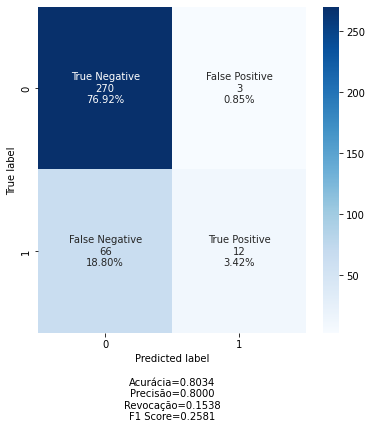

In [147]:
ml_SVC = SVC()

train_model(ml_SVC)

<h3>Naive Bayes</h3>

In [72]:
ml_GNB = CategoricalNB()

train_model(ml_GNB)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



IndexError: ignored

<h3>Árvore de decisão</h3>

'TreeDecision.pdf'

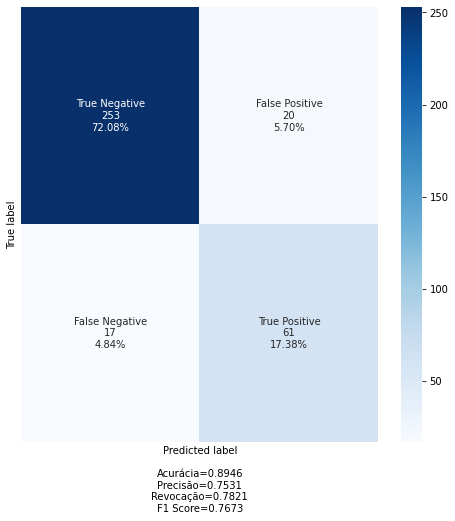

In [113]:
ml_DT = DecisionTreeClassifier(random_state=64)

train_model(ml_DT)

from sklearn import tree
import graphviz 

dot_data = tree.export_graphviz(ml_DT, 
                                out_file=None,
                                class_names=np.array(['Compatível','Incompatível']),
                                feature_names=X.columns)
graph = graphviz.Source(dot_data)
graph.render("TreeDecision")

In [87]:
y_pred = ml_DT.predict(X_test)
y_pred

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [88]:
print(np.array(y['incompatibil'].to_list()))

[1 1 0 ... 0 0 0]


In [89]:
ml_DT

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=64, splitter='best')

In [94]:
ml_DT_a_scores_CV = cross_val_score(ml_DT, X_train, y_train, cv = 10)
print(f'Média das Acurácias calculadas pelo CV....: {100*round(ml_DT_a_scores_CV.mean(),4)}')
print(f'std médio das Acurácias calculadas pelo CV: {100*round(ml_DT_a_scores_CV.std(),4)}')
ml_DT_a_scores_CV

Média das Acurácias calculadas pelo CV....: 90.81
std médio das Acurácias calculadas pelo CV: 3.18


array([0.86585366, 0.90243902, 0.96341463, 0.92682927, 0.86585366,
       0.87804878, 0.9382716 , 0.91358025, 0.88888889, 0.9382716 ])

In [95]:
from time import time

In [96]:
import seaborn as sns

In [97]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

In [121]:
def GridSearchOptimizer(modelo, ml_Opt, d_hiperparametros, X_train, y_train, X_test, y_test, i_CV):
    ml_GridSearchCV = GridSearchCV(modelo, d_hiperparametros, cv = i_CV, n_jobs = -1, verbose= 10, scoring = 'accuracy')
    start = time()
    ml_GridSearchCV.fit(X_train, y_train)
    tempo_elapsed = time()-start
    print(f"\nGridSearchCV levou {tempo_elapsed:.2f} segundos.")

    # Hiperparâmetros que otimizam a classificação:
    print(f'\nHiperparâmetros otimizados: {ml_GridSearchCV.best_params_}')

    if ml_Opt == 'ml_DT2':
      print(f'\nDecisionTreeClassifier *********************************************************************************************************')
      ml_Opt = DecisionTreeClassifier(criterion= ml_GridSearchCV.best_params_['criterion'], 
                                    max_depth= ml_GridSearchCV.best_params_['max_depth'],
                                    max_leaf_nodes= ml_GridSearchCV.best_params_['max_leaf_nodes'],
                                    min_samples_split= ml_GridSearchCV.best_params_['min_samples_leaf'],
                                    min_samples_leaf= ml_GridSearchCV.best_params_['min_samples_split'], 
                                    random_state= 64)

    # Treina novamente usando os hiperparâmetros otimizados...
    ml_Opt.fit(X_train, y_train)

    # Cross-Validation com 10 folds
    print(f'\n********* CROSS-VALIDATION ***********')
    a_scores_CV = cross_val_score(ml_Opt, X_train, y_train, cv = 10)

    # Faz predições com os hiperparâmetros otimizados...
    y_pred = ml_Opt.predict(X_test)

    # Importância das COLUNAS
    print(f'\n********* IMPORTÂNCIA DAS COLUNAS ***********')
    df_importancia_variaveis = pd.DataFrame(zip(X.columns, ml_Opt.feature_importances_), columns= ['coluna', 'importancia'])
    df_importancia_variaveis = df_importancia_variaveis.sort_values(by= ['importancia'], ascending=False)
    print(df_importancia_variaveis)

    # Matriz de Confusão
    print(f'\n********* CONFUSION MATRIX - PARAMETER TUNNING ***********')
    cf_matrix = confusion_matrix(y_test, y_pred)
    cf_labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    cf_categories = ['0', '1']
    mostra_confusion_matrix(cf_matrix, group_names = cf_labels, categories = cf_categories)

    return ml_Opt, ml_GridSearchCV.best_params_

In [119]:
d_hiperparametros_DT = {"criterion": ["gini", "entropy"], 
                   "min_samples_split": [2, 5, 10, 270, 350, 400], 
                   "max_depth": [None, 2, 5, 9, 15], 
                   "min_samples_leaf": [1.0, 20, 40, 100], 
                   "max_leaf_nodes": [None, 2, 3, 15]}
d_hiperparametros_DT

{'criterion': ['gini', 'entropy'],
 'max_depth': [None, 2, 5, 9, 15],
 'max_leaf_nodes': [None, 2, 3, 15],
 'min_samples_leaf': [1.0, 20, 40, 100],
 'min_samples_split': [2, 5, 10, 270, 350, 400]}

Fitting 10 folds for each of 960 candidates, totalling 9600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0112s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0309s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0467s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0841s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 396 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 716 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 892 t


GridSearchCV levou 46.96 segundos.

Hiperparâmetros otimizados: {'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 20, 'min_samples_split': 2}

DecisionTreeClassifier *********************************************************************************************************

********* CROSS-VALIDATION ***********

********* IMPORTÂNCIA DAS COLUNAS ***********
                    coluna  importancia
14                  fob_kg     0.552642
5           vl_frete_dolar     0.177945
7      valor_un_prod_dolar     0.077530
1                   pais_1     0.067666
11     valor_frete_rateado     0.052593
3         qtde_estatistica     0.051263
6          vl_seguro_dolar     0.004955
0                     pais     0.004554
2      unidade_desembaraco     0.004121
4               vmle_dolar     0.004054
10    peso_liquido_rateado     0.002676
8            qtd_comercial     0.000000
9        tot_un_prod_dolar     0.000000
12          seguro_rateado     0.000000
13  t

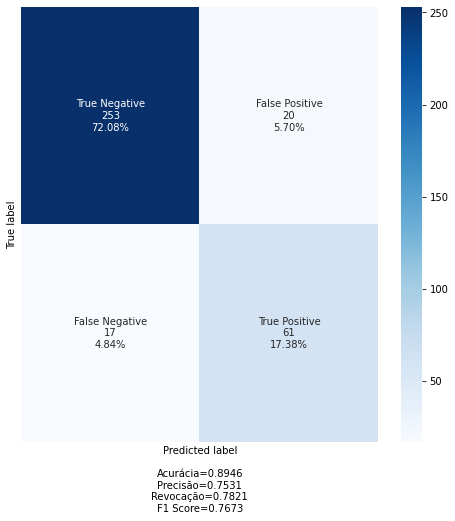

In [120]:
ml_DT2, best_params = GridSearchOptimizer(ml_DT, 'ml_DT2', d_hiperparametros_DT, X_train, y_train, X_test, y_test, i_CV)

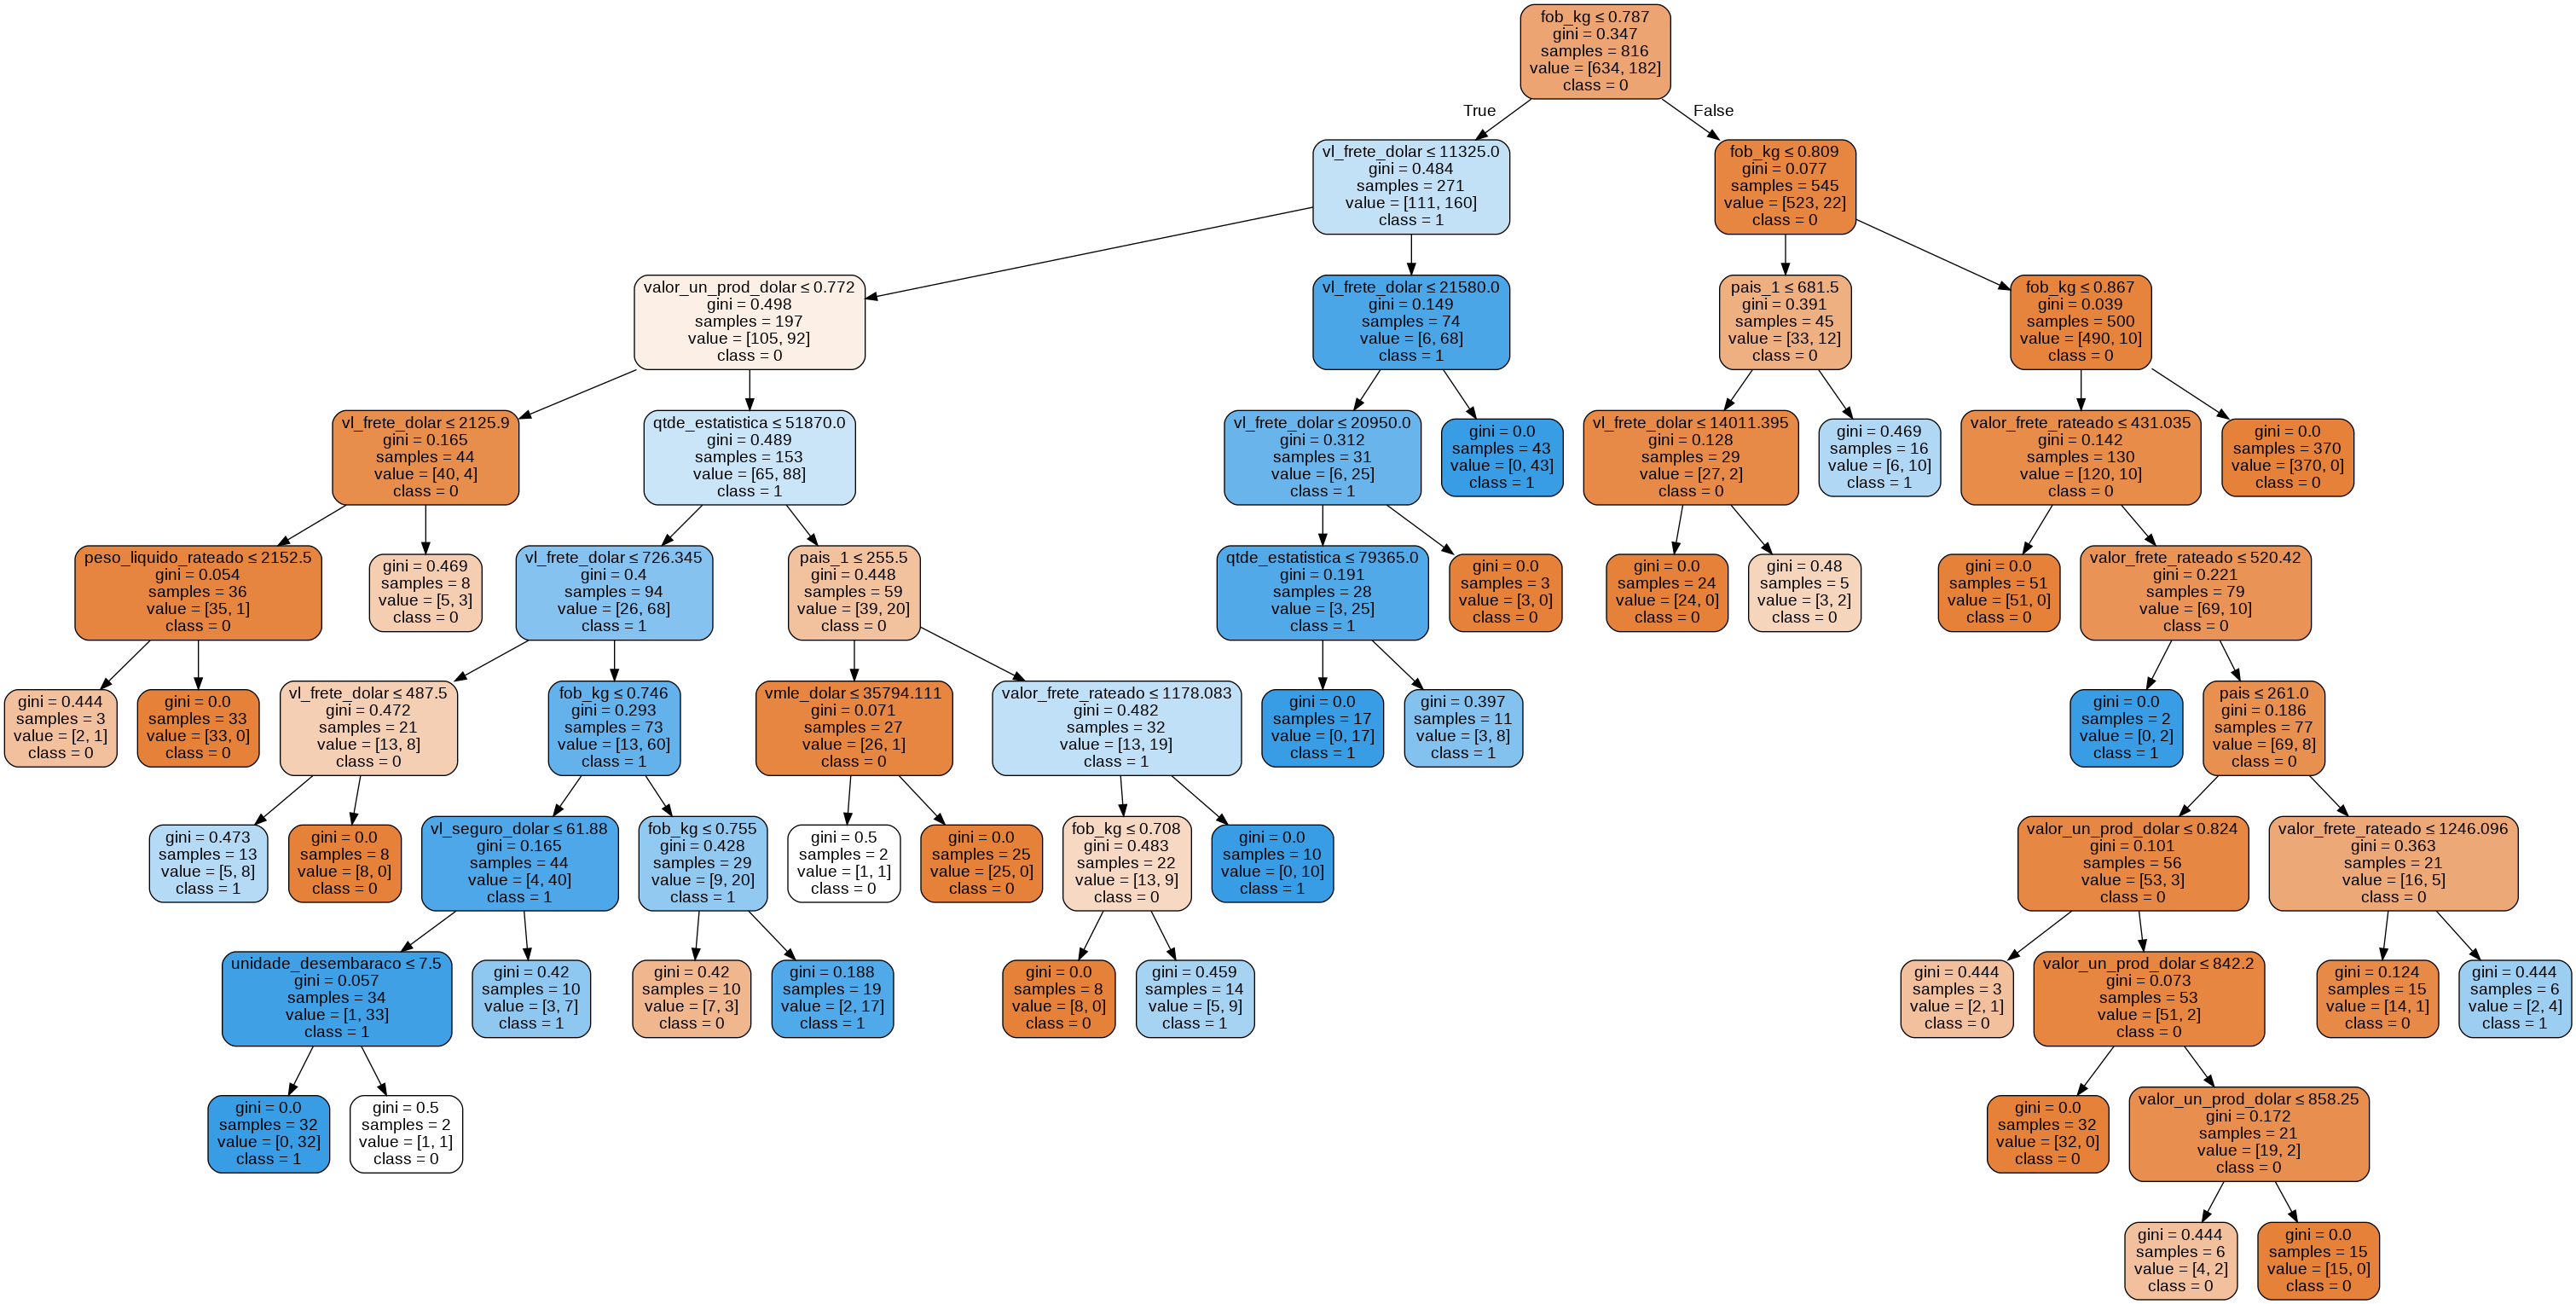

In [116]:
dot_data = StringIO()
export_graphviz(ml_DT2, out_file = dot_data, filled = True, rounded = True, special_characters = True, feature_names = X.columns, class_names = ['0','1'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('DecisionTree.png')
Image(graph.create_png())

Acurácia: 0.9316
Precision: 0.8
Revocação: 0.9231
F1 Score: 0.8571


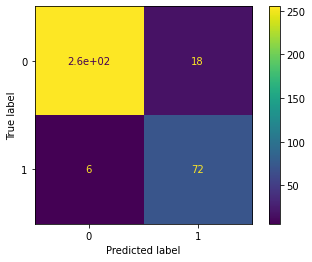

'TreeDecision.pdf'

In [ ]:
ml_DT = DecisionTreeClassifier(criterion='entropy', max_depth= None, max_leaf_nodes=None, min_samples_leaf= 20, min_samples_split= 2, random_state=64)

train_model(ml_DT)

from sklearn import tree
import graphviz 

dot_data = tree.export_graphviz(ml_DT, 
                                out_file=None,
                                class_names=np.array(['Compatível','Incompatível']),
                                feature_names=X.columns)
graph = graphviz.Source(dot_data)
graph.render("TreeDecision")

In [ ]:
ml_DT_a_scores_CV = cross_val_score(ml_DT, X_train, y_train, cv = 10)
print(f'Média das Acurácias calculadas pelo CV....: {100*round(ml_DT_a_scores_CV.mean(),4)}')
print(f'std médio das Acurácias calculadas pelo CV: {100*round(ml_DT_a_scores_CV.std(),4)}')
ml_DT_a_scores_CV

Média das Acurácias calculadas pelo CV....: 88.84
std médio das Acurácias calculadas pelo CV: 3.46


array([0.8902439 , 0.93902439, 0.8902439 , 0.8902439 , 0.84146341,
       0.91463415, 0.9382716 , 0.82716049, 0.87654321, 0.87654321])